In [32]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack

import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html
import re

In [33]:
PATH_TO_DATA = '/Users/user/Dropbox/ods/alice/'
SEED = 17

In [34]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    train_df = train_df.loc[(train_df.time1 < '2014-04-16') & (train_df.time1 > '2013-02-12')]

    
    # Reading site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # Create an inverse id _> site mapping
    id2site = {v:k.replace('www.', '') for (k, v) in site2id.items()}
    # We treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
        
    # We'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # So that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # To be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # We'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [35]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 25000,
                       'sublinear_tf': True,
                       'tokenizer': lambda s: s.split()}
)

Wall time: 48.1 s


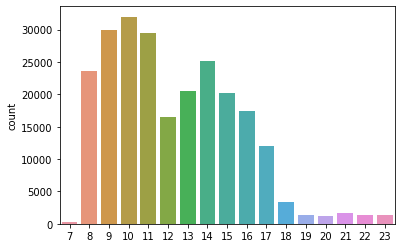

In [36]:
# Lets draw the distribution of all session start hours
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values
sns.countplot(session_start_hour)

Now the same separately for Alice and everybody else.

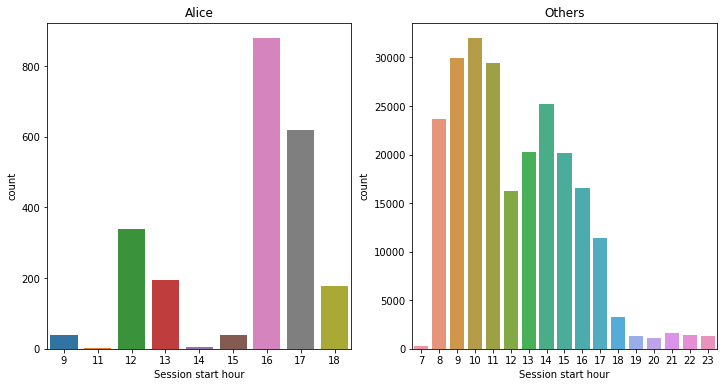

In [37]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

Now we definitely see that Alice mostly prefers 4-5 pm for browsing

In [38]:
time_split = TimeSeriesSplit(n_splits=10)

In [39]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [40]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [41]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [42]:
# Adding new features
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)

    month = times['time1'].apply(lambda ts: ts.month)
    summer = ((month >= 6) & (month <= 8)).values.reshape(-1, 1)

    alice_hour = [12,13,16,17,18]
    alice_hours = hour.apply(lambda x: 1 if x in alice_hour else 0).values.reshape(-1, 1)
    
    session_duration = ((times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2).values.reshape(-1, 1)
    number_of_sites = times.isnull().sum(axis=1).apply(lambda x: 10 - x).astype('int').values.reshape(-1, 1)
    time_per_site = ((session_duration / number_of_sites) ** 0.2).astype('int')
    
    objects_to_hstack = [X_sparse, morning, day, evening, summer, number_of_sites, time_per_site, alice_hours]
    feature_names = ['summer', 'morning', 'day', 'evening', 'number_of_sites', 'time_per_site', 'alice_hours']
    
    if add_hour:
        # We'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [43]:
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)

In [44]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [45]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [46]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    
    # Linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5

    objects_to_hstack = [X_sparse, day_of_week, year_month]
    feature_names = ['day_of_week','year_month']
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [47]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [48]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='alice_subm.csv')

CV scores [0.87797528 0.84368018 0.91704513 0.95379435 0.95888487 0.95544836
 0.94341706 0.9313181  0.97352958 0.97330229]
CV mean: 0.9328395194045406, CV std: 0.040304685025825134


Weight?,Feature
+5.226,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.933,melty.fr
+4.619,audienceinsights.net
+4.288,info-jeunes.net
+4.281,r4---sn-gxo5uxg-jqbe.googlevideo.com
+4.192,vk.com
+4.124,youwatch.org
+4.045,banque-chalus.fr
+3.936,video.tt
+3.610,fr.glee.wikia.com


New feature weights:
           feature      coef
0           summer -0.773439
1          morning  0.228250
2              day -1.009819
3          evening -2.221441
4  number_of_sites  0.098524
5    time_per_site -0.232480
6      alice_hours  3.346274
7    sess_duration -0.145808
8      day_of_week -0.313351
9       year_month -3.377683


In [49]:
# Here we've already narrowed down c_values to such a range
c_values = np.logspace(-3, 1, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [50]:
%%time
logit_grid_searcher.fit(X_train_final, y_train); 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


Wall time: 3min 22s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='wa...
             param_grid={'C': array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-0

In [51]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9350360716974566, {'C': 2.3357214690901213})

In [52]:
final_model = logit_grid_searcher.best_estimator_

In [53]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='alice_subm_final.csv')

CV scores [0.89322821 0.82687777 0.92224881 0.9597258  0.95912693 0.95437731
 0.94961893 0.93985813 0.97042058 0.97487824]
CV mean: 0.9350360716974567, CV std: 0.04271889387982625


Weight?,Feature
+8.240,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.699,banque-chalus.fr
+5.698,melty.fr
+5.298,video.tt
+5.182,audienceinsights.net
+5.166,r4---sn-gxo5uxg-jqbe.googlevideo.com
+5.015,browser-update.org
+4.978,info-jeunes.net
+4.744,demotivateur.disqus.com
+4.611,fr.glee.wikia.com


New feature weights:
           feature      coef
0           summer -0.643810
1          morning  0.287778
2              day -1.342091
3          evening -2.822577
4  number_of_sites  0.173273
5    time_per_site -0.205600
6      alice_hours  3.471187
7    sess_duration -0.127744
8      day_of_week -0.315660
9       year_month -3.957884
